# Forcasting precipitations in Morocco communes 2000-2018 data

## Preparing Data

In [1]:
import psycopg2
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conn = psycopg2.connect('dbname=wm-22-precip-DB user=postgres password=postgres host=localhost')
cur = conn.cursor()

In [4]:
sql_colnms = """SELECT column_name
FROM INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = N'prepMa'"""

sql_prepMa = '''SELECT * FROM "prepMa"'''

In [5]:
d = pd.read_sql_query(sql_prepMa,conn)
conn.close()

/home/ayoub/miniconda3/envs/ml/lib/python3.10/site-packages/pandas/io/sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
mapIdMap = dict(zip(d['name'], d['fid']))

In [7]:
df = d.copy()

In [8]:
df.set_index(['id'])
df.drop(columns=['objectid', 'geom', 'fid', 'name', 'id'], inplace=True)
df_ = df.T
df_.index = pd.to_datetime([f'{i[:7]}' for i in df_.index])
df_.sort_index(inplace=True)
df_.head()

,0,1,2,3,4,5,6,7,8,9,...,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541
2000-01-01,5.139662,5.185174,12.736306,7.222152,8.277916,10.003084,3.690965,4.015777,3.724388,3.973375,...,80.943738,53.279457,58.557885,42.157584,37.573582,37.573582,37.573582,37.573582,39.338377,40.711483
2000-02-01,2.320398,2.510182,7.483267,3.029178,3.857246,4.342615,2.725529,1.264757,2.803877,1.386363,...,1.866421,1.128736,1.365121,0.964586,0.890602,0.890602,0.890602,0.890602,0.922023,1.099783
2000-03-01,1.026504,0.911228,4.644095,0.968059,2.144454,1.894135,1.811047,1.650475,1.805033,0.908379,...,28.641492,19.283579,24.587897,5.983350,6.307444,6.307444,6.307444,6.307444,6.350355,3.502182
2000-04-01,0.994122,0.929610,3.478880,0.909780,1.619741,1.273522,1.302462,0.677425,1.902222,0.860408,...,95.467146,113.049248,108.450883,72.007683,69.569077,69.569077,69.569077,69.569077,70.999270,56.441982
2000-05-01,0.000000,0.000000,0.749234,0.000000,0.010291,0.000000,0.000000,0.974401,0.000000,0.984279,...,46.760845,48.911781,53.525117,21.432269,22.532732,22.532732,22.532732,22.532732,21.880218,18.199196


In [9]:
df_.to_csv('precipCommunesTS.csv')

Link to this ~cleaned dataset : [🔗](https://drive.google.com/file/d/1E34cl3U9q_U5NC96G3l8uGWorlRwqfTQ/view?usp=sharing)

## EDA precipitation of Khouribga commune

In [10]:
mapIdMap['Khouribga']

332

In [11]:
df_kh = pd.DataFrame(df_[332])

In [12]:
df_kh.rename(columns={332: "precipKhouribga"}, inplace=True)

In [13]:
df_kh.head()

,precipKhouribga
2000-01-01,13.872842
2000-02-01,7.474373
2000-03-01,2.075285
2000-04-01,38.477597
2000-05-01,7.025321


In [14]:
sns.set()

### Plotting the variation of precipitation in Khouribga commune over the years

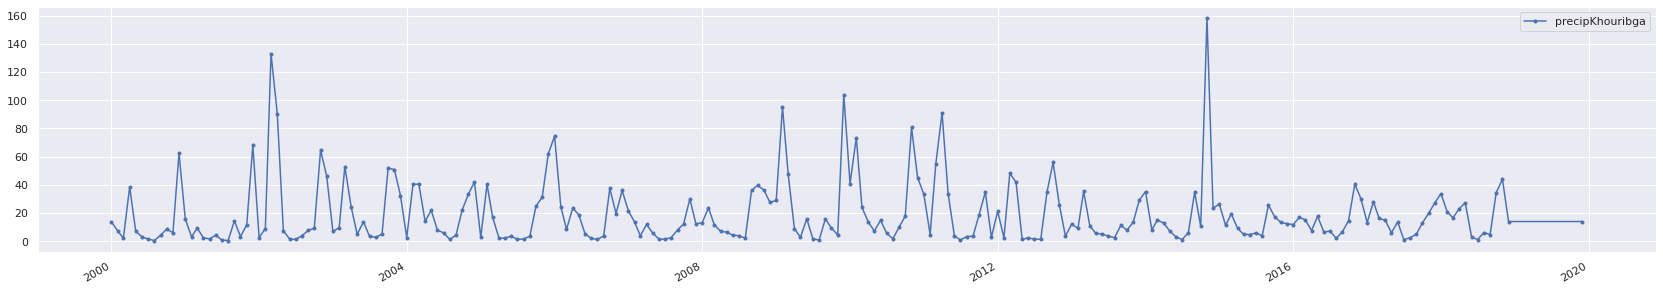

In [15]:
df_kh.plot(marker='.', figsize=(29,5));

#### Stationarity test

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df_kh)

if pvalue < 0.05:
    print(f"Data stationary, pvalue = {pvalue}")
else:
    print(f"Data NOT stationary, pvalue = {pvalue}")

Data stationary, pvalue = 0.004213471277470053


Creating columns containing year and month to see if there is any trends with respect to years and months.

In [18]:
df_kh['year'] = [d.year for d in df_kh.index]
df_kh['month'] = [d.strftime('%b') for d in df_kh.index]
df_kh.head()

,precipKhouribga,year,month
2000-01-01,13.872842,2000,Jan
2000-02-01,7.474373,2000,Feb
2000-03-01,2.075285,2000,Mar
2000-04-01,38.477597,2000,Apr
2000-05-01,7.025321,2000,May


<AxesSubplot:xlabel='year', ylabel='precipKhouribga'>

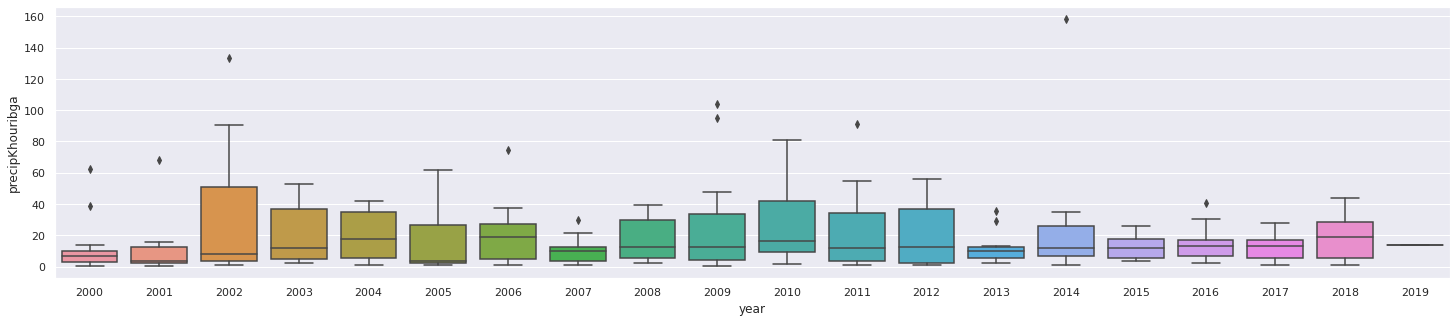

In [19]:
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(x='year', y="precipKhouribga", data=df_kh, ax=ax)

<AxesSubplot:xlabel='month', ylabel='precipKhouribga'>

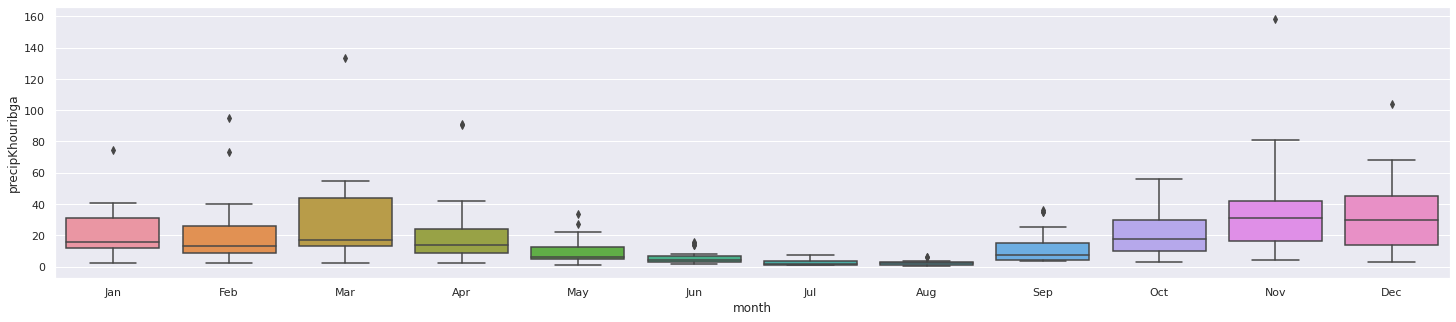

In [20]:
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(x='month', y="precipKhouribga", data=df_kh, ax=ax)

#### Extract and plot trend, seasonal and residuals

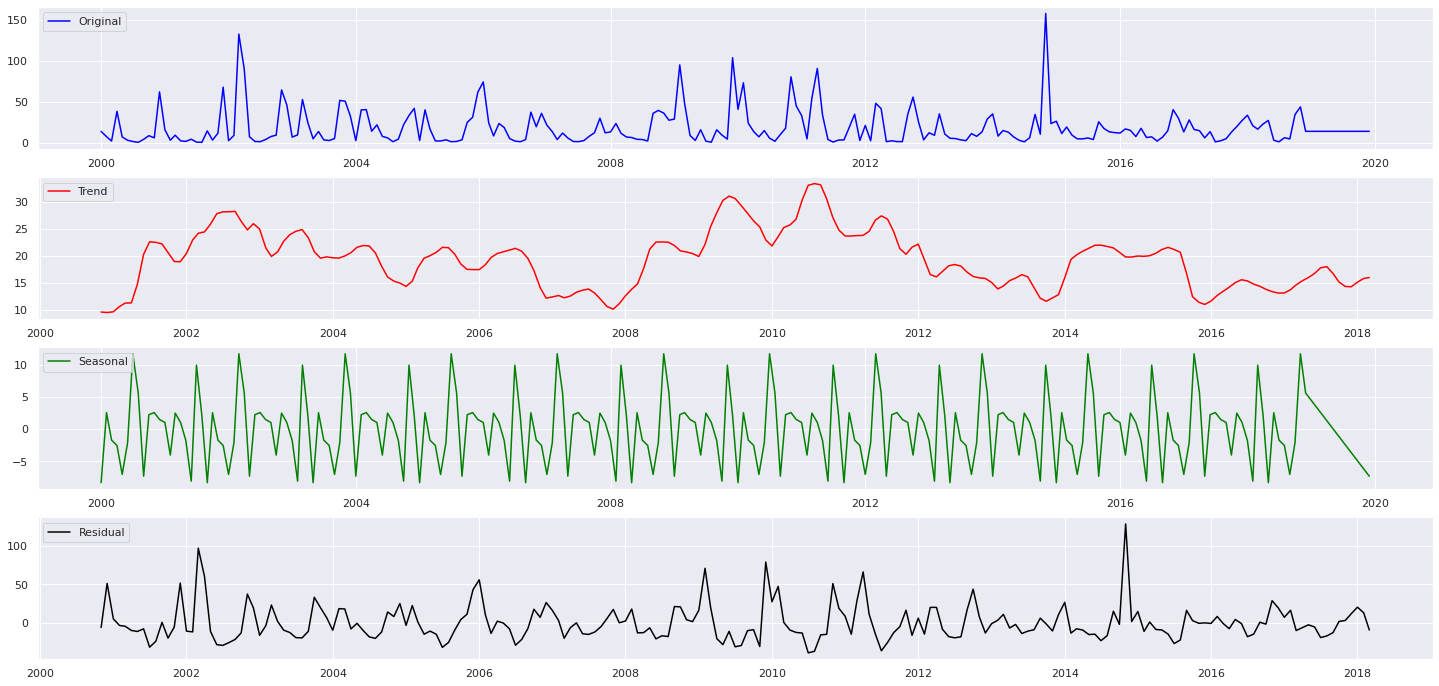

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df_kh['precipKhouribga'], model ='additive', period=20)

#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

plt.figure(figsize=(25,12))
plt.subplot(411)
plt.plot(df_kh['precipKhouribga'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

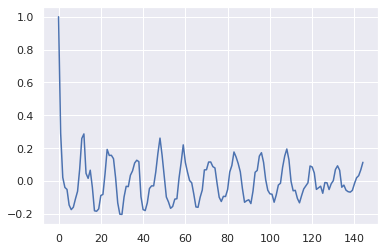

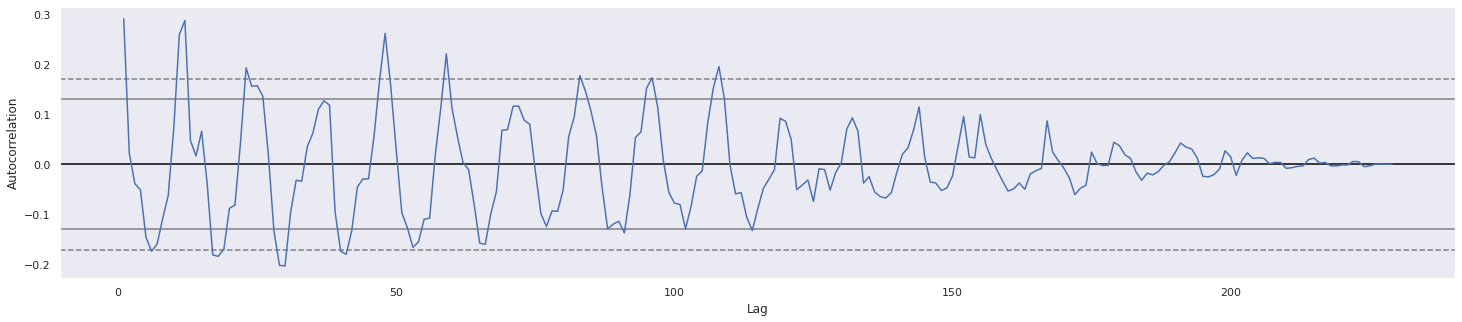

In [22]:

#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.

from statsmodels.tsa.stattools import acf

acf_144 = acf(df_kh['precipKhouribga'], nlags=144)
plt.plot(acf_144)

#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(figsize=(25, 5))
autocorrelation_plot(df_kh['precipKhouribga'],ax=ax) 